In [155]:
import openmc.deplete as dpl
import openmc
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import matplotlib as mpl
params = {'image.aspect':'equal',
          'savefig.dpi':600,
          'axes.grid':True,
          'axes.grid.which':"major",
          'font.size':12,
          'text.usetex':True,
          'text.color':'black',
          'image.cmap':'viridis'}
mpl.rcParams.update(params)

openmc.config['chain_file'] = "chain_endfb71_pwr.xml"
dpl_chain = dpl.chain.Chain.from_xml(openmc.config['chain_file'])

In [164]:
class Heat:
    def __init__(self, results):
        self.times, self.heat = results.get_decay_heat('1',by_nuclide=True)
        
        heat_dict = {nuc:[] for nuc in self.heat[0].keys()}
        for i in range(len(self.times)):
            for nuc, value in self.heat[i].items():
                heat_dict[nuc].append(value)

        self.heat_dict = heat_dict
        _, self.total_heat = results.get_decay_heat('1')

    def __bool__(self):
        return True

    def __call__(self, nuclide, want_warn=False):
        return_arr = np.array(self.heat_dict[nuclide])
        
        if return_arr.size != self.times.size:
            if want_warn:
                print(f'Warning! {nuclide} heat has size {return_arr.size} not {self.time.sizes}! Padding with final heat value.')
            return np.pad(return_arr, (0,self.times.size-return_arr.size), mode='edge')

        return return_arr

    def plot(self, ax):
        ax.semilogy(self.times, self.total_heat, label = 'Total Heat')

class Element:
    def __init__(self, Elem: str, results, heat):

        self.name = Elem
        self.__find_nucs()
        self.__unpack_atoms(results)
        self.__unpack_heat(heat)
        return
    

    def __find_nucs(self):
        nucs = []
        for i in range(300):
            try:
                temp = self.name + str(i)
                results.get_atoms('1', temp)
                nucs.append(temp)
            except:
                pass
        self.nucs = nucs
        return
        
    def __unpack_atoms(self, results):
        atom_dict = {}
        for nuc in self.nucs:
            self.times, atom_dict[nuc] = results.get_atoms('1', nuc)
        self.atom_dict = atom_dict
        self.total_atoms = sum(self.atom_dict.values())
        return

    def __unpack_heat(self, heat):
        heat_dict = {}
        for nuc in self.nucs:
            heat_dict[nuc] = heat(nuc)
        self.heat_dict = heat_dict
        self.total_heat = sum(heat_dict.values())

    def __call__(self, name=None):
        
        if name:
            return self.atom_dict[name]
            
        return self.total_atoms
        
    def __getitem__(self, name=None):
        if name:
            return self.heat_dict[name]

        return self.total_heat

    def plot(self, ax, name=None, by_type='at', at_lim = 1e7, ht_lim = 1e3):
        plot = True
        if by_type == 'at':
            values= self(name) / 48710000.0 #fuel salt volume in core
            if np.max(values) < at_lim:
                plot = False
        else:
            values = self[name]
            if np.max(values) < ht_lim:
                plot = False

        label = name if bool(name) else self.name
        if plot:
            ax.semilogy(self.times, values, label = label)
        return

def at_finisher(path=None):
    ax.legend()
    ax.set_xlim(0,600)
    ax.set_ylim(bottom=1e6, top=1.32383200984734e+22)
    ax.set_ylabel("Number Density\quad [at $\cdot$ cm$^{-3}$]")
    ax.set_xlabel("Time\quad [s]")
    if path:
        fig.savefig('newplots/'+path+'.png', dpi=600)

def ht_finisher(path=None):
    ax.legend()
    ax.set_xlim(0,600)
    ax.set_ylabel("Decay Heat\quad [W]")
    ax.set_xlabel("Time\quad [s]")
    if path:
        fig.savefig('newplots/'+path+'.png', dpi=600)

In [163]:
results = dpl.Results('results/depletion_results.h5')
heat = Heat(results)

# Gases

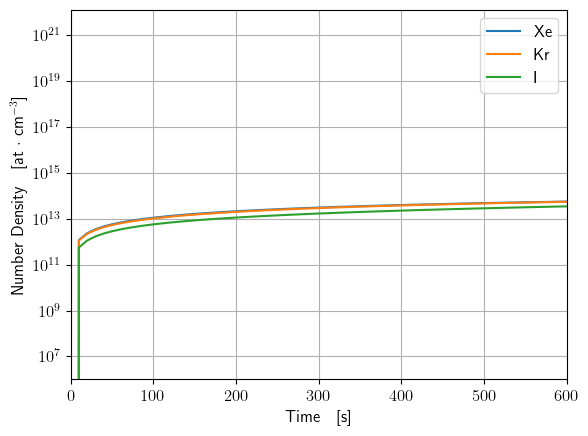

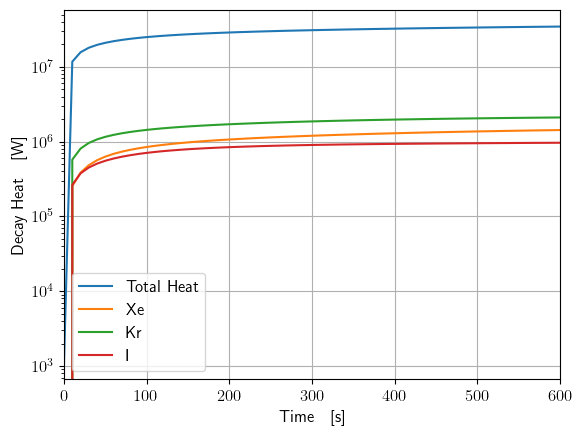

In [165]:
gases = ["Xe", "Kr", "I"]
elems = [Element(elem, results, heat) for elem in gases]

fig, ax = plt.subplots()
for elem in elems:
    elem.plot(ax)
at_finisher('gas_conc')

fig, ax = plt.subplots()
heat.plot(ax)
for elem in elems:
    elem.plot(ax, by_type='ht')
ht_finisher('gas_heat')

# Noble Metals

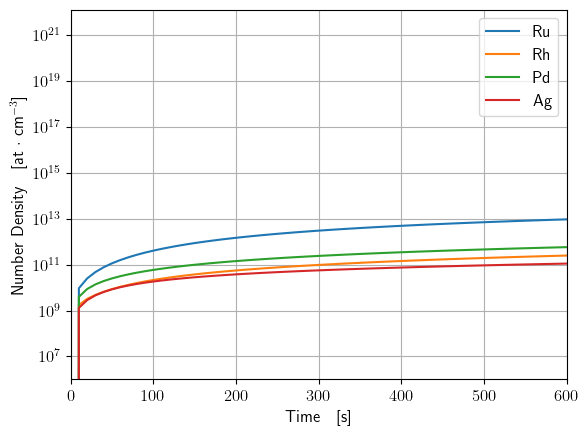

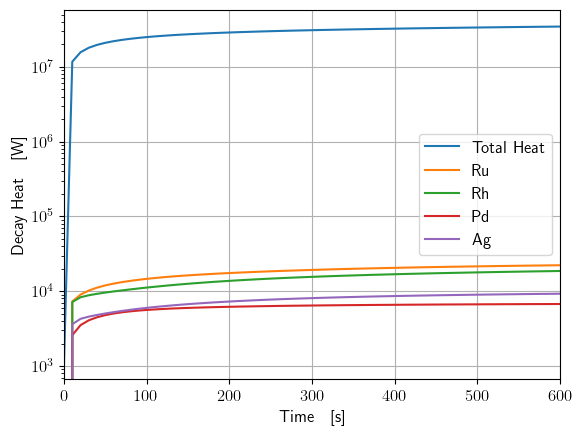

In [166]:
noble_metals = ["Ru","Rh","Pd","Ag"]
elems = [Element(elem, results, heat) for elem in noble_metals]

fig, ax = plt.subplots()
for elem in elems:
    elem.plot(ax)
at_finisher('nm_conc')

fig, ax = plt.subplots()
heat.plot(ax)
for elem in elems:
    elem.plot(ax, by_type='ht')
ht_finisher('nm_heat')

# Lanthanides

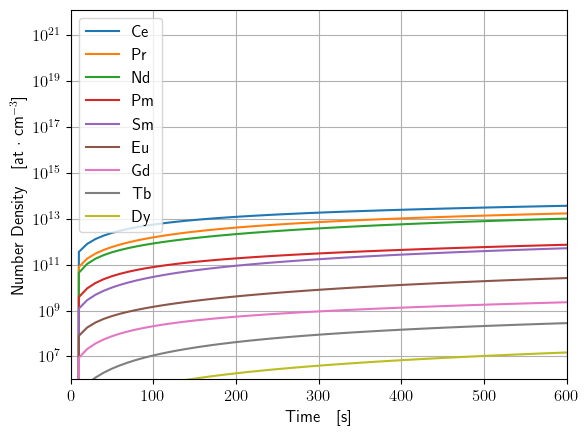

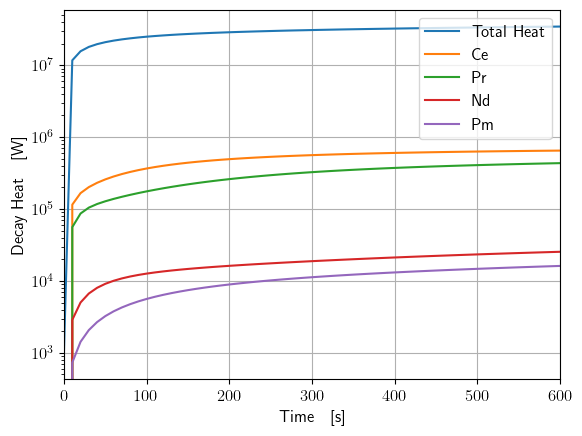

In [167]:
lanthanides = ["Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Yb", "Lu"]
elems = [Element(elem, results, heat) for elem in lanthanides]

fig, ax = plt.subplots()
for elem in elems:
    elem.plot(ax)
at_finisher('lan_conc')

fig, ax = plt.subplots()
heat.plot(ax)
for elem in elems:
    elem.plot(ax, by_type='ht')
ht_finisher('lan_heat')

# Actinides

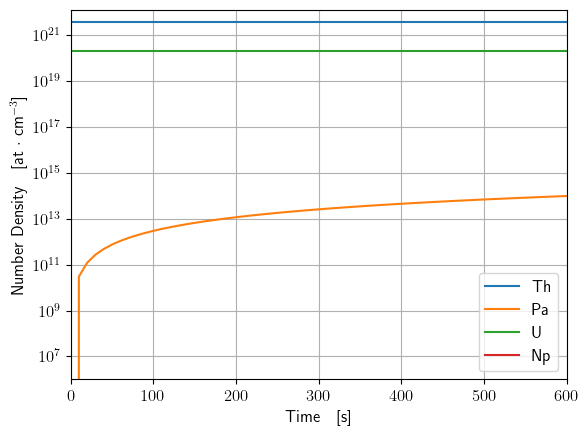

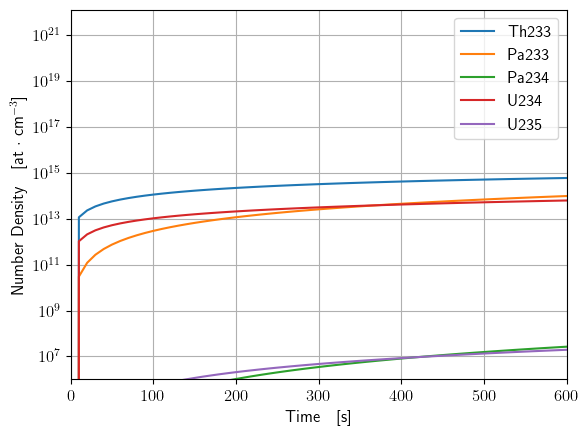

In [168]:
isos = ["Th233", "Pa233", "Pa234", "U234", "U235"]
ids = [0, 1, 1, 2, 2]
actinides = ['Th', 'Pa', 'U', 'Np']
elems = [Element(elem, results, heat) for elem in actinides]

fig, ax = plt.subplots()
for elem in elems:
    elem.plot(ax, at_lim=0)
at_finisher('act_conc')

fig, ax = plt.subplots()
for i, iso in zip(ids, isos):
    elems[i].plot(ax, name=iso)
at_finisher('act_heat')